# TODO:
- Add something to add a minimap to the delta_twtt plot to show one point in the general area of the crossover points for quick reference
    - or add a plot to the side which displays the continent and a "you are here" star marker IVO the crossover points
- **Implement multi flight crossover point finding**
- average the 2 points on each leg rather than must picking one
- select for 45° crossovers to see if delta_twtt is ~0
- add the Cross class to the class library
- revise the code from cross_points down to utilize the Cross class

In [1]:
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.transforms import ScaledTranslation

from project_classes import *
from functions import *
# from scipy.optimize import curve_fit
# import scipy.optimize as opt

# %matplotlib notebook 


In [2]:
zoom = True
seg_length = 100
# season = "2009_Antarctica_DC8"
season = "2018_Antarctica_DC8" 
season = "2016_Antarctica_DC8" 
# season = "2014_Antarctica_DC8" 
# season = "2022_Antarctica_BaslerMKB"

# flight = "20181030_01"  # the flight date and frame number 
    # that flight only has one point
# flight = "20181018_01"
# flight = "20181103_01"
# flight = "20181011_01"
    # one dimensional data error
    # TODO: figure out why 10018 and 1103 have the same data or at least print the same maps and plots
# flight = "20181109_01"
# flight = "20181112_02"  # the problem flight
    # plots fake crossovers along the curved path
# flight = "20161111_05"
    # probably too close to the coast to be useful
flight = "20161024_05"
flight = "20161014_05"
    # todo: figure out why there are weird None values for some of the iceflow stuff in this run
        # hopefully it is contained to this run

# flight = "20141025_05"
# flight = "20141026_06"
    # this one is 1/3 of an orbit and produces a bunch of bunk crossovers
# flight = "20230127_01"
    # ~ 1/3 of an orbit of the pole and yet the angle plot looks like hot garbage
# flight = "20230125_01"
# flight = "20221229_01"
# file_name = "layer_export_" + flight + ".pickle"
file_name = f"pickle_jar\\layer_export_{flight}.pickle"
# file_name = "C:\\Users\\rj\\Desktop\\cresis_project\\pickle_jar\\layer_export_" + flight + ".pickle"
# file_name = f"C:\\Users\\{username}\\Desktop\\cresis_project\\pickle_jar\\{season}_{flight}_layers.pickle"
testing = False

In [3]:
"""
read in the layers from the layer files and save them to a pickle file
"""
force = False
# force = True
whole_season = False
# whole_season = True

if whole_season:  # if the whole season is being read in
    print(type(dir))
    file_name = dir + season + ".pickle"
    # print(f"filename: {filename}")
    if not os.path.isfile(file_name):  # if the file does not exist
        debug_print(BRIGHT_RED, f"File {file_name} does not exist. You should make it...")
    else:
        layers = read_layers(file_name)
        print(f"File {file_name} loaded.")
else:  # if only one flight is being read in
    if not force:
        if not os.path.isfile(file_name):  # if the file does not exist
            print(f"File {file_name} does not exist. Making it...")
            mat_pickler_h5py(season, flight, testing_mode=testing)  # make it
            layers = read_layers(file_name)  # read in the layers from the pickle file
            print(f"File {file_name} created.")
        else:
            layers = read_layers(file_name)  # read in the layers from the pickle file
            print(f"File {file_name} loaded.")
    else:
        mat_pickler_h5py(season, flight, testing_mode=testing)  # make it
        layers = read_layers(file_name)  # read in the layers from the pickle file

File pickle_jar\layer_export_20161014_05.pickle does not exist. Making it...
Reading data files...
--------------------
DEBUG: Opened C:\Users\moser\Documents\cresis\rds\2016_Antarctica_DC8\CSARP_layer\20161014_05\Data_20161014_05_001.mat with h5py
--------------------
Reading pickle file...
--------------------
Surface
Bottom
--------------------

File pickle_jar\layer_export_20161014_05.pickle created.


### read in the iceflow data from the iceflow data files and save them to a pickle file

In [4]:
if not os.path.isfile(f"C:\\Users\\{username}\\Desktop\\cresis_project\\iceflow\\iceflow_data.pickle"):  # if the file does not exist
    print("The iceflow data pickle file was not found. Creating a new one...")
    filename = iceflow_saver()
    iceflow_data = iceflow_loader(filename)
    print("The iceflow data pickle file was successfully created.")
# try:
iceflow_data = iceflow_loader("C:\\Users\\moser\\Desktop\\cresis_project\\iceflow\\iceflow_data.pickle")
print("The iceflow data pickle file was found and loaded.")

ice_x = iceflow_data[0]
ice_y = iceflow_data[1]
# ice_x = iceflow_data[1]
# ice_y = iceflow_data[0]
ice_velocity_x = iceflow_data[2]
ice_velocity_y = iceflow_data[3]
ice_latitude = iceflow_data[4]
ice_longitude = iceflow_data[5]
print("iceflow data loaded")
# TODO: 10July24 - are the x and y arrays swapped, is that why things are bunk? Check against QGIS.
    # the xy coordinates need to be input backwards to get the right point

The iceflow data pickle file was found and loaded.
iceflow data loaded


In [5]:
# x_index= 6000
x_index = 7500  # column
y_index = 6000  # row

print(f"ice_x[{x_index}]: \t\t\t\t\t{ice_x[x_index]}, {ice_y[y_index]}")
print(f"ice_y[{x_index}]]: \t\t\t\t\t{ice_y[y_index]}")
print("")
print(f"ice_velocity_x[{y_index}][{x_index}]: \t{ice_velocity_x[y_index][x_index]}")
print(f"ice_velocity_y[{y_index}][{x_index}]: \t{ice_velocity_y[y_index][x_index]}")
print(f"ice_latitude[{y_index}][{x_index}]: \t\t{ice_latitude[y_index][x_index]}")
print(f"ice_longitude[{y_index}][{x_index}]: \t\t{ice_longitude[y_index][x_index]}")

# x_val = index_to_x(x_index)
# y_val = index_to_y(y_index)

# print(f"x_val: {x_val}, y_val: {y_val}")


ice_x[7500]: 					575000.0, 100000.0
ice_y[7500]]: 					100000.0

ice_velocity_x[6000][7500]: 	-2.2737696170806885
ice_velocity_y[6000][7500]: 	-1.9776984453201294
ice_latitude[6000][7500]: 		-84.6322319677139
ice_longitude[6000][7500]: 		80.13419367766448


In [6]:
# if the file at filename exists, read in the intersect_indices and intersection_points from the pickle file
# otherwise, find the intersect_indices and intersection_points and save them to a pickle file
force_redo_intersections = False
# force_redo_intersections = True
filename = f"C:\\Users\\moser\\Desktop\\cresis_project\\pickle_jar\\{season}_{flight}_crossover_points.pickle"
if not os.path.isfile(filename) or force_redo_intersections:  # if the file does not exist
    print(f"File {filename} does not exist. Making it...")
    intersection_points, intersection_indices, segment_ends = cross_point(layers[0], seg_length, quiet=True)
    with open(filename, 'wb') as file:
        pickle.dump(intersection_indices, file)
        pickle.dump(intersection_points, file)
        pickle.dump(segment_ends, file)
    print(f"intersection_indices and intersection_points saved to {filename}")
else:
    with open(filename, 'rb') as file:
        intersection_indices = pickle.load(file)
        intersection_points = pickle.load(file)
        segment_ends = pickle.load(file)
    print(f"intersection_indices and intersection_points loaded from {filename}")

intersection_indices and intersection_points loaded from C:\Users\moser\Desktop\cresis_project\pickle_jar\2016_Antarctica_DC8_20161014_05_crossover_points.pickle


In [7]:
# TODO: identify why this is still here and not in the functions file
    # because it is still being tweaked
# TODO: consider normalizing to the elevation, not the surface
    # i.e. instead of having the surface be flat, have it represent the actual topology
    # really only useful for places where the surface is not basically flat 
def plot_layers_at_cross(layers, intersection_indices, intersection_points, zoom=False, refractive_index=1.77, cross_index=0, filename=None):
    """
    :param layers: a list of Layer objects
    :param intersection_indices: a list of indices in the lat-lon arrays where the flight path
    crosses over itself
    :param intersection_points: a list of lat-lon points where the flight path crosses over itself
    :return: nothing (plots the layers and the map)
    """
    micro = chr(956)
    def s_to_ms(x, pos):
        """
        :param x: the x value
        :param pos: the position
        :return: the x value in milliseconds
        """
        return '%1.2f' % (x * 1e6)

    # plt.figure(figsize=(16, 8), layout='constrained')
    fig, ax = plt.subplots(figsize=(16, 8), layout='constrained')
    # print("Plotting layers...")
    # print("--------------------")
    # print("Adjusting for surface twtt...")
    for layer in layers:
        corrected_layer = layer.twtt - layers[0].twtt
        layer.twtt_corrected = corrected_layer


    # offset = 500
    offset = 30
    
    """
    with surface normalization
    """
    # ax.plot(
    #     layers[1].twtt_corrected[intersection_indices[cross_index][0] - offset:intersection_indices[cross_index][0] + offset],
    #     label=layers[1].layer_name + ' segment 1')
    # ax.plot(
    #     layers[1].twtt_corrected[intersection_indices[cross_index][1] - offset:intersection_indices[cross_index][1] + offset],
    #     label=layers[1].layer_name + ' segment 2')

    # plot the crossover point on the plot 
    ax.scatter(offset, layers[1].twtt_corrected[intersection_indices[cross_index][0]], color='red', label='X Point 1')
    ax.scatter(offset, layers[1].twtt_corrected[intersection_indices[cross_index][1]], color='green', label='X Point 2')
    
    """
    without surface normalization
    """
    # # plot the surface layers
    # ax.plot(layers[0].twtt[intersection_indices[cross_index][0] - offset:intersection_indices[cross_index][0] + offset],
    #         label=layers[0].layer_name + ' segment 1', linestyle='--')
    # ax.plot(layers[0].twtt[intersection_indices[cross_index][1] - offset:intersection_indices[cross_index][1] + offset],
    #         label=layers[0].layer_name + ' segment 2', linestyle='--')
    
    # ax.plot(
    #     layers[1].twtt[intersection_indices[cross_index][0] - offset:intersection_indices[cross_index][0] + offset],
    #     label=layers[1].layer_name + ' segment 1')
    # ax.plot(
    #     layers[1].twtt[intersection_indices[cross_index][1] - offset:intersection_indices[cross_index][1] + offset],
    #     label=layers[1].layer_name + ' segment 2')
    # 
    # plot the crossover point on the plot 
    # ax.scatter(offset, layers[1].twtt[intersection_indices[cross_index][0]], color='magenta', label='X Point 1')
    # ax.scatter(offset, layers[1].twtt[intersection_indices[cross_index][1]], color='blue', label='X Point 2')
    
    
    n = refractive_index
    c = 299792458  # m/s
    v = c / n
    # depth = twtt * v / 2
    scale_factor = v / 2
    
    # print the twtt at the crossover point on both segments
    # twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=)
    # twtt = twtt_at_point(layers[1], layers[0], intersection_indices,corrected=True, quiet=True)[cross_index]
    twtt = layers[1].twtt_corrected[intersection_indices[cross_index][0]], layers[1].twtt_corrected[intersection_indices[cross_index][1]]
    print(f"twtt: {twtt}")    

    ax.axvline(x=offset, color='black', label='X Point', linestyle='--', linewidth=0.3)
    ax.axhline(y=twtt[0], color='red', label='X Point 1', linestyle='--', linewidth=0.3)
    ax.axhline(y=twtt[1], color='green', label='X Point 2', linestyle='--', linewidth=0.3)
    
    # plot a line from twtt[0] to twtt[1] to show the delta twtt
    delta_twtt = twtt[1] - twtt[0]
    delta_twtt_ms = float(s_to_ms(delta_twtt, None))
    ax.plot([offset*0.1, offset*0.1], [twtt[0], twtt[1]], color='black', label='Delta TWTT', linewidth=0.3)
    ax.text(offset*0.08, (twtt[0] + twtt[1]) / 2, f"{delta_twtt_ms:.3f}{micro}s", fontsize='smaller', ha='right', va='center', color='black')
    
    # plot a line from twtt[0] to twtt[1] to show the delta twtt in meters
    delta_depth = twtt_to_depth(delta_twtt, refractive_index=n)
    ax.plot([offset*1.9, offset*1.9], [twtt[0], twtt[1]], color='black', label='Delta Depth', linewidth=0.3)
    ax.text(offset*1.92, (twtt[0] + twtt[1]) / 2, f"{delta_depth:.3f}m", fontsize='smaller', ha='left', va='center', color='black')
    
    # plot a horizontal line from (offset - 5) to (offset + 5) to show the distance scale
    start = layers[1].twtt_corrected[intersection_indices[cross_index][0] - 5]
    end = layers[1].twtt_corrected[intersection_indices[cross_index][0] + 5]
    for point in range(intersection_indices[cross_index][0] - 5, intersection_indices[cross_index][0] + 5):
        if layers[1].twtt_corrected[point] > start:
            start = layers[1].twtt_corrected[point]
            # print(f"start: {start}")
    for point in range(intersection_indices[cross_index][1] - 5, intersection_indices[cross_index][1] + 5):
        if layers[1].twtt_corrected[point] > start:
            start = layers[1].twtt_corrected[point]
            # print(f"start: {start}")
    # minimum = min(start, end)
    minimum = max(start, end)
    pixel_offset = 20  # offset 20 pixels
    trans = ax.transData + ScaledTranslation(0, -pixel_offset / fig.dpi, ax.figure.dpi_scale_trans)
        
    ax.plot([offset - 5, offset + 5], [minimum, minimum], transform=trans, color='black', label='Distance Scale', linewidth=0.3)
    location1_lat = layers[1].lat[intersection_indices[cross_index][0] - 5]
    location1_lon = layers[1].lon[intersection_indices[cross_index][0] - 5]
    location2_lat = layers[1].lat[intersection_indices[cross_index][0] + 5]
    location2_lon = layers[1].lon[intersection_indices[cross_index][0] + 5]
    distance = latlon_dist((location1_lat, location1_lon), (location2_lat, location2_lon))
    # ax.text(offset, minimum, f"{distance:.2f}m", fontsize='smaller', ha='center', va='top', color='black')
    ax.annotate(f"{distance:.3f}m", (offset, minimum), xycoords='data', xytext=(0, -5), textcoords='offset points', fontsize='smaller', ha='center', va='top', color='black')
        # because the plane is moving so fast, speed is constant → distance is constant → this value will be the same in each plot
    
    # set the y axis to be in microseconds instead of seconds
    plt.ylabel(f"Adjusted Two Way Travel Time ({micro}s)")
    plt.xlabel("Index")

    # force the y values to be displayed in 1e-6 ticks (microseconds) instead of 1e-5 ticks (tens of microseconds)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    

    # set the y axis to be in microseconds instead of seconds
    # plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(s_to_ms))
        # set 5 subticks on the y axis
    # plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.000000005))
    # ax.gca().yaxis.set_minor_locator(ax.MultipleLocator(0.5 / 1e6))
    plt.legend( fontsize='smaller', loc='lower right')

    # make the right side y axis show the depth in meters by converting the twtt to depth using the refractive index
    min_y, max_y = plt.ylim()
    # n = refractive_index
    # c = 299792458  # m/s
    # v = c / n
    # # depth = twtt * v / 2
    # scale_factor = v / 2
    # print(f"scale factor: {scale_factor}")
    # plt.twinx()
    # plt.ylim(min_y * scale_factor, max_y * scale_factor)
    # plt.ylabel("Depth (m)")
    sec_y = ax.twinx()
    sec_y.set_ylim(min_y * scale_factor, max_y * scale_factor)
    sec_y.set_ylabel("Depth (m)")
    sec_y.invert_yaxis()
    ax.invert_yaxis()


    # make the top of the x axis be the distance in meters by converting the lat-lon to distance using the haversine formula
    min_x, max_x = plt.xlim()
    scale_factor = latlon_dist((layers[0].lat[0], layers[0].lon[0]), (layers[0].lat[1], layers[0].lon[1]))
    # print(f"scale factor: {scale_factor}")
    # plt.gca().invert_yaxis()

    plt.twiny()
    plt.xlim(min_x * scale_factor, max_x * scale_factor)
    plt.xlabel("Distance (m)")

    plt.title(f"Adjusted Two Way Travel Time vs Index\n Cross Index {cross_index + 1}")
    
    dir = f"C:\\Users\\{username}\\Desktop\\cresis_project\\screens\\"
    file_name = f"{season}_{flight}_twtt_vs_index_cross_{cross_index + 1}"
    plt.savefig(f"{dir}{file_name}.png", dpi=250)
    
    plt.show()

def bunk_plot(custom_text=None, file_name=None):
    """
    plot a null plot
    """
    plt.figure(figsize=(6, 3), layout='constrained')
    plt.title(f"Bunk Plot")
    plt.text(0.5, 0.5, f"Bunk Plot", fontsize='32', fontweight='bold', ha='center', va='center', color='black')
    if custom_text:
        plt.text(0.5, 0.4, custom_text, fontsize='16', fontweight='bold', ha='center', va='center', color='black')
    if file_name:
        plt.savefig(f"{file_name}.png", dpi=250)
    plt.show()

def plot_map(layers, intersection_indices, intersection_points, iceflow_data, season, flight,  zoom=False, cross_index=0, filename=None):
    """
    plot the map
    """
    plot_it = True
    printout = False
    
    if plot_it:
        plt.figure(figsize=(16, 8), layout='constrained')
    print("Plotting map...")
    # TODO: add an offset to the zoom settings so that the crossover point is in the center of the zoomed in map
    offset = 500  # this is not that offset

    # this code sets up a polar stereographic map of antarctica with the South Pole in the center
    # zoom_out_to_continent = not zoom
    zoom_out_to_continent = zoom
    if zoom_out_to_continent:
        llcrnrx = -400000
        llcrnry = -400000
        urcrnrx = 250000
        urcrnry = 250000
    else:
        llcrnrx = -300000
        llcrnry = -300000
        urcrnrx = 300000
        urcrnry = 300000
    # lat_0 = intersection_points[cross_index][0]
    # lon_0 = intersection_points[cross_index][1]
    #lat_0 is the average of the latitudes of the crossover points
    #lon_0 is the average of the longitudes of the crossover points
    lat_0 = sum([point[0] for point in intersection_points]) / len(intersection_points)
    lon_0 = sum([point[1] for point in intersection_points]) / len(intersection_points)
    
    # print(f"debug: lat_0: {lat_0}, lon_0: {lon_0}")
    if plot_it:
        m = Basemap(projection='ortho', lat_0=lat_0, lon_0=lon_0, llcrnrx=llcrnrx, llcrnry=llcrnry, urcrnrx=urcrnrx, urcrnry=urcrnry, resolution='h')
        # m = Basemap(projection='spstere', lat_0=-90, lat_ts=-71, lon_0=0, boundinglat=-80, resolution='c')
        m.drawcoastlines()
        m.fillcontinents(color='grey', lake_color='aqua')
        m.drawparallels(np.arange(-80., 81., 20.))
        m.drawmeridians(np.arange(-180., 181., 20.))
        m.drawmapboundary(fill_color='aqua')
    
        # plot the flight path
        m.plot(layers[0].lon, layers[0].lat, latlon=True, color='lightgreen', linewidth=1)
        # plot the section of the flight path in the plot above
        m.plot(layers[0].lon[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
               layers[0].lat[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset], latlon=True,
               color='red', linewidth=1)
        m.plot(layers[0].lon[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset],
               layers[0].lat[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset], latlon=True,
               color='green', linewidth=1)
        # plot labels for the flight paths at their start points
        plt.text(
            m(layers[0].lon[intersection_indices[0][0] - offset], layers[0].lat[intersection_indices[0][0] - offset])[0],
            m(layers[0].lon[intersection_indices[0][0] - offset], layers[0].lat[intersection_indices[0][0] - offset])[1],
            '\nsegment 1', fontsize='smaller', fontweight='bold', ha='right', va='top', color='red')
        plt.text(
            m(layers[0].lon[intersection_indices[0][1] - offset], layers[0].lat[intersection_indices[0][1] - offset])[0],
            m(layers[0].lon[intersection_indices[0][1] - offset], layers[0].lat[intersection_indices[0][1] - offset])[1],
            '\nsegment 2', fontsize='smaller', fontweight='bold', ha='left', va='top', color='green')
        # plot the South Pole
        # m.scatter(0, -90, latlon=True, color='black', linewidth=1, label='South Pole')
        # plot the crossover points
        for point in intersection_points:
            m.scatter(point[1], point[0], latlon=True, color='darkred', linewidth=1, label='Crossover Point')
            plt.text(m(point[1], point[0])[0], m(point[1], point[0])[1] - 10000, f'{intersection_points.index(point) + 1}\n\n',
                     fontsize='smaller', fontweight='bold', ha='center', va='top', color='darkred')

    # m.scatter(intersection_points[cross_index][1], intersection_points[cross_index][0], latlon=True, color='darkred',
    #           linewidth=1, label='Crossover Point')
    # plt.text(m(intersection_points[cross_index][1], intersection_points[cross_index][0])[0],
    #          m(intersection_points[cross_index][1], intersection_points[cross_index][0])[1] - 10000,
    #          'Crossover Point\n\n',
    #          fontsize='smaller', fontweight='bold', ha='center', va='top', color='darkred')

    # plot the the ice flow direction at the crossover point
    for i in range(len(intersection_indices)):
    # for i in range(1):
        cross_lat = intersection_points[i][0]
        cross_lon = intersection_points[i][1]
        if cross_lon < 0:
            cross_lon = 360 + cross_lon
        cross_x, cross_y = latlon_to_xy(cross_lat, cross_lon)  
        """Outputs x and y in EPSG:3031"""
    

        
        # nearest_x_index, nearest_y_index = xy_to_nearest_unmasked_index(cross_x, cross_y, iceflow_data, max_radius=10)
        # nearest_y_index, nearest_x_index = latlon_to_nearest_unmasked_index(cross_lat, cross_lon, iceflow_data, max_radius=10)
        nearest_x_index, nearest_y_index = latlon_to_nearest_unmasked_index(cross_lat, cross_lon, iceflow_data, max_radius=10)
        
        """Outputs the nearest x and y indices to the x and y EPSG:3031 values"""
        
        
        nearest_lat = iceflow_data[4][nearest_y_index][nearest_x_index]  # latitude = iceflow_data[4]
        nearest_lon = iceflow_data[5][nearest_y_index][nearest_x_index]  # longitude = iceflow_data[5]
        # nearest_lon = - (iceflow_data[5][nearest_x_index][nearest_y_index] - 270)  # longitude = iceflow_data[5]
        
        # print(f"nearest_lat: {nearest_lat:.4f}, nearest_lon: {nearest_lon:.4f}")
        

        nearest_x, nearest_y = index_to_x(nearest_x_index), index_to_y(nearest_y_index)
        
    
        # flow = flow_at_x_y_index(nearest_x_index, nearest_y_index, iceflow_data)
        vx, vy = iceflow_data[2][nearest_y_index][nearest_x_index], iceflow_data[3][nearest_y_index][nearest_x_index]
        flow = [vx, vy]
        
        
        flow_heading = xyindex_vector_to_heading(nearest_x_index, nearest_y_index, flow[0], flow[1])[0]
        # m.quiver(intersection_points[0][1], intersection_points[0][0], 1000 * np.cos(np.radians(flow_heading)),
        #          1000 * np.sin(np.radians(flow_heading)), latlon=True, color='blue', label='Ice Flow Vector')
        # plot the ice flow vector in the upper right corner as a quiver
        

        if printout:
            print(f"cross index: {i+1}")
            print(f"cross_lat: {cross_lat:.8}, cross_lon: {cross_lon:.8f}") 
            print(f"cross_x: {cross_x:.4f}, cross_y: {cross_y:.4f}")
            print(f"nearest_x_index: {nearest_x_index}, nearest_y_index: {nearest_y_index}")
            print(f"nearest_lat: {nearest_lat}, nearest_lon: {nearest_lon}")
            print(f"nearest_x: {nearest_x:.4f}, nearest_y: {nearest_y:.4f}")
            print(f"flow at nearest: {flow}")
            print("")
            print(f"Diff x: {(cross_x - nearest_x):.1f}, Diff y: {(cross_y - nearest_y):.1f}")
            print("")
            print(section_break)
            print(section_break)
            print("")
        
        m.quiver(nearest_x, nearest_y, 10000 * np.cos(np.radians(flow_heading)), 10000 * np.sin(np.radians(flow_heading)), latlon=True, color='blue', label='Ice Flow Vector')
        x, y = m(0, -90)
    
        # plt.text(x, y, '\nSouth Pole', fontsize='smaller', fontweight='bold', ha='center', va='top', color='black')

    # center_x, center_y = latlon_to_xy(intersection_points[cross_index][0], intersection_points[cross_index][1])
    center_x, center_y = latlon_to_xy(lat_0, lon_0)
    center_x = x_to_index(center_x)
    center_y = y_to_index(center_y)
    search_range = 750
    steps = 50
    start_time = time.time()
    for x in range(-1 * search_range + center_x, search_range + center_x, steps):
        current = x + search_range - center_x    
        progress_bar(current,  2 * search_range, start_time)
        for y in range(-1 * search_range + center_y, search_range + center_y, steps):
            if not (
                np.ma.is_masked(iceflow_data[2][y][x]) and np.ma.is_masked(iceflow_data[3][y][x])
                ):

                vx = 1 * iceflow_data[2][y][x]
                vy = 1 * iceflow_data[3][y][x]
                flow = [vx, vy]
                flow_heading = xyindex_vector_to_heading(x, y, flow[0], flow[1])[0]
                scale = 0.0005
                mag = np.sqrt(vx**2 + vy**2) * scale
                lat = iceflow_data[4][y][x]
                lon = iceflow_data[5][y][x]
                m.scatter(lon, lat, latlon=True, color='darkred', s=0.75)
                # plot a line of length mag in the direction of the flow vector to show the flow vector
                endpt = [lon + mag * np.cos(np.radians(flow_heading)), lat + mag * np.sin(np.radians(flow_heading))]
                m.plot([lon, endpt[0]], [lat, endpt[1]], latlon=True, color='blue', linewidth=0.5)
                
            # else:
                # print(f"masked at x: {x}, y: {y}")
        # scatter the south pole
        # m.scatter(0, -90, latlon=True, color='white', s=5)
        # print("")
        
    print("")
    if plot_it: 
        plt.title("Lat-Lon Map")
        # set tight layout
        # plt.tight_layout()
    
        # save the plot
        if filename:
            # plt.savefig(f"{filename}.png", dpi=250)
            dir = "C:\\Users\\moser\\Desktop\\cresis_project\\screens\\"
            savename = f"{dir}{filename}_map.png"
            print(f"saving to {savename}...")
            plt.savefig(savename, dpi=150)
        
        print("drawing to screen...")
        plt.show()

    # print("plotted map")
    # print(section_break + "\n")

In [8]:
# print(segment_ends[0][0][0][0])
twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)

# for i in range(len(segment_ends)):
# # for i in range(0,2):
#     print(f"cross {i+1}; i: {i}")
#     # if the twtt at the cross is a nan
#     if math.isnan(twtt[i][0]) or math.isnan(twtt[i][1]):
#         print(f"twtt at cross {i+1} is nan")
#         dir = f"C:\\Users\\{username}\\Desktop\\cresis_project\\screens\\"
#         file_name = f"{season}_{flight}_twtt_vs_index_cross_{i + 1}"
#         long_name = dir + file_name
#         bunk_plot(f"twtt at cross {i+1} is NaN", file_name=long_name)
#         continue
#         
#     plot_layers_at_cross(layers, intersection_indices, intersection_points, zoom=zoom, cross_index=i, filename=(season + flight + "crossover"))

# plot_map(layers, intersection_indices, intersection_points, iceflow_data, season, flight,  zoom=False, cross_index=0, filename=(season + flight + "crossover")) 

- set up separate bottom slope plot and correct bottom slope code
    - bottom slope could be represented incorrectly due to surface slope
    - the two twtts still need to be normalized to the surface in all other calculations
        - the plane to surface distance/twtt could theoretically be different per leg of the flight
            - i.e. the plane may have different altitudes at the same location 
    - <img src="layer_plot_notes.png" height=600>

In [9]:
for layer in layers:
        corrected_twtt = layer.twtt - layers[0].twtt  # normalize against the surface layer
        # corrected_twtt = layer.twtt
        layer.twtt_corrected = corrected_twtt

In [10]:
# print(segment_ends[0])
print(segment_ends[0])
print()
print(segment_ends[0][0][0][0])
print(segment_ends[0][0][0][0][0])
leg_1 = segment_ends[0][0][0]
leg_2 = segment_ends[0][1][0]
# print(f"leg_1: {leg_1}")
# print(f"leg_2: {leg_2}")

[[[(-72.23647688927026, -69.92573985009878), (-72.23649460470514, -69.92617633223382)], 30937, 30938], [[(-72.23649889621416, -69.92602253178818), (-72.23637201145795, -69.92616790297188)], 120771, 120772]]

(-72.23647688927026, -69.92573985009878)
-72.23647688927026


lat_0: -72.23647688927026, lon_0: -69.92573985009878
lat_0: -72.23647688927026, lon_0: -69.92573985009878
intersection_points[0]: [-72.23647688927026, 290.0742601499012]
-72.23647688927026 -69.92573985009878
DEBUG: -69.92573985009878
DEBUG: -72.23649889621416-69.92602253178818


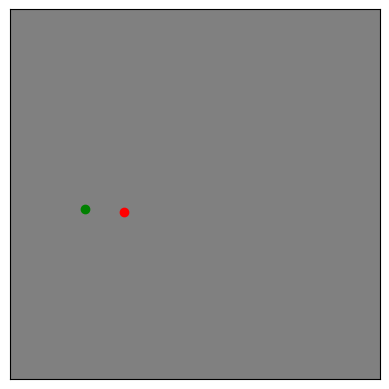

In [11]:
# plot the two legs
lat_0 = segment_ends[0][0][0][0][0]
lon_0 = segment_ends[0][0][0][0][1]

print(f"lat_0: {lat_0}, lon_0: {lon_0}")
# if lon_0 < 0:
    # lon_0 = 360 + lon_0
# if lon_0 > 180:
    # lon_0 = (lon_0 - 180)
print(f"lat_0: {lat_0}, lon_0: {lon_0}")

# print the first intersection point
print(f"intersection_points[0]: {intersection_points[0]}")
scale = 25
llcrnrx = -scale
llcrnry = -scale
urcrnrx = scale
urcrnry = scale
offset = 20000

print(leg_1[0][0], leg_1[0][1])
        
m = Basemap(projection='ortho', lat_0=leg_1[0][0], lon_0=leg_1[0][1], llcrnrx=llcrnrx, llcrnry=llcrnry, urcrnrx=urcrnrx, urcrnry=urcrnry, resolution='l')
# m = Basemap(projection='spstere', lat_0=-90, lat_ts=-71, lon_0=0, boundinglat=-80, resolution='c')
m.drawcoastlines()
m.fillcontinents(color='grey', lake_color='aqua')
m.drawparallels(np.arange(-80., 81., 20.))
m.drawmeridians(np.arange(-180., 181., 20.))

debug_print(BRIGHT_MAGENTA, layers[0].lon[intersection_indices[0][0]])

# plot the flight path
# m.plot(layers[0].lon, layers[0].lat, latlon=True, color='lightgreen', linewidth=1)
# plot the section of the flight path in the plot above
# m.plot(layers[0].lon[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
       # layers[0].lat[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset], latlon=True,
       # color='green', linewidth=.25)

# debug_print(BRIGHT_MAGENTA, leg_2[0], leg_2[0])
debug_print(BRIGHT_MAGENTA, leg_2[0][0], leg_2[0][1])

# m.scatter(intersection_points[0][0], intersection_points[0][1], color='darkred', linewidth=1, label='Crossover Point')

# m.scatter(lon_0, lat_0, latlon=True, color='red', linewidth=0.5, label='Leg 1')
m.scatter(leg_2[0][1], leg_2[0][0], latlon=True, color='red', linewidth=1, label='Leg 2')
m.scatter(leg_1[1][1], leg_1[1][0], latlon=True, color='green', linewidth=1, label='Leg 1')

plt.show()

In [12]:
for i in range(len(segment_ends) - 1):
    print(i)
    print(f"corrected_twtt[{segment_ends[i][0][1]}]: \t\t{corrected_twtt[segment_ends[i][0][1]]}")
    print(f"corrected_twtt[{segment_ends[i][0][2]}]: \t\t{corrected_twtt[segment_ends[i][0][2]]}")
    delta = corrected_twtt[segment_ends[i][0][1]] - corrected_twtt[segment_ends[i][0][2]]
    
    # print(f"corrected_twtt[segment_ends[{i}][0][2]]: \t\t{corrected_twtt[segment_ends[i][0][2]]}")
    # print(f"corrected_twtt[segment_ends[{i}][1][2]]: \t\t{corrected_twtt[segment_ends[i][1][2]]}")
    # delta = corrected_twtt[segment_ends[i][1][2]] - corrected_twtt[segment_ends[i][0][2]]
    print(f"delta: \t{delta}")
    print(f"depth: \t{twtt_to_depth(delta, refractive_index=1.77)}")
    print(section_break)


0
corrected_twtt[30937]: 		5.66273593133962e-06
corrected_twtt[30938]: 		5.660932007992457e-06
delta: 	1.8039233471637254e-09
depth: 	0.1527691000818646
--------------------
1
corrected_twtt[40440]: 		1.3596298861801616e-05
corrected_twtt[40441]: 		1.357767209011264e-05
delta: 	1.862677168897484e-08
depth: 	1.5774479291645704
--------------------
2
corrected_twtt[45800]: 		1.3205110993219135e-05
corrected_twtt[45801]: 		1.322564594934108e-05
delta: 	-2.053495612194502e-08
depth: 	-1.7390466018983182
--------------------


In [13]:
class Cross:
    def __init__(self):
        self.cross_number = None
        self.flow_xy = None
        self.flow_v = None
        self.intersect_indices = None
        
        self.leg_1 = None
        self.leg_1_ave = None
        self.leg_1_indices = None
        self.leg_2 = None
        self.leg_2_ave = None
        self.leg_2_indices = None
        self.leg_1_twtt_ave = None
        self.leg_2_twtt_ave = None
        self.delta_twtt = None
        self.leg_1_depth_ave = None
        self.leg_2_depth_ave = None
        self.depth_ave = None

        self.flow_heading_full = None
        self.flow_heading = None
        self.plane_heading_1 = None
        self.plane_heading_2 = None
        self.angle = None
        # self.twtt = None

    
    # def to_dict(self):
    #     return {
        #     'flow_xy': self.flow_xy,
        #     'flow_heading_full': self.flow_heading_full,
        #     'flow_heading': self.flow_heading,
        #     'plane_heading_1': self.plane_heading_1,
        #     'plane_heading_2': self.plane_heading_2,
        #     'angle': self.angle,
        #     'twtt': self.twtt,
        #     'delta_twtt': self.delta_twtt,
        #     'depth1': self.depth1,
        #     'depth2': self.depth2,
        #     'depth_ave': self.depth_ave
        # }

          
    def to_dict(self):
        return self.__dict__

    def __str__(self):
        # attributes = self.to_dict()
        # str_repr = '\n'.join(f"{key}: {value}" for key, value in attributes.items())
        
        str_repr = dir(self)
        for key in str_repr:
            if key[0] != "_":
                str_repr.pop(key)
        
        return str_repr



In [14]:
# corrected_twtt[segment_ends[i][0][2]]
# corrected_twtt[0]
print(segment_ends[0])
print()
print(segment_ends[0][0][0][1])
print(segment_ends[0][0][2])
print(corrected_twtt[segment_ends[0][0][2]])
print(segment_ends[0][0][0])
print(segment_ends[0][1])



[[[(-72.23647688927026, -69.92573985009878), (-72.23649460470514, -69.92617633223382)], 30937, 30938], [[(-72.23649889621416, -69.92602253178818), (-72.23637201145795, -69.92616790297188)], 120771, 120772]]

(-72.23649460470514, -69.92617633223382)
30938
5.660932007992457e-06
[(-72.23647688927026, -69.92573985009878), (-72.23649460470514, -69.92617633223382)]
[[(-72.23649889621416, -69.92602253178818), (-72.23637201145795, -69.92616790297188)], 120771, 120772]


In [15]:
for i in range(len(intersection_indices)):
    # pull the points and indices out of the segment_ends list to make the code more readable
    points_leg_1 = segment_ends[0][0][0]  # both end points of the first leg
    points_leg_2 = segment_ends[0][1][0]
    indices_leg_1 = segment_ends[0][0][1:3]  # both indices of the first leg
    indices_leg_2 = segment_ends[0][1][1:3]
    
    # find the twtts from the indices
    leg_1_twtt_1 = corrected_twtt[indices_leg_1[0]]
    leg_1_twtt_2 = corrected_twtt[indices_leg_1[1]]
    leg_2_twtt_1 = corrected_twtt[indices_leg_2[0]]
    leg_2_twtt_2 = corrected_twtt[indices_leg_2[1]]
    
    # find the average lat and lon of the two legs
    leg_1_ave_lat = (points_leg_1[0][0] + points_leg_1[1][0]) / 2
    leg_1_ave_lon = (points_leg_1[0][1] + points_leg_1[1][1]) / 2
    leg_2_ave_lat = (points_leg_2[0][0] + points_leg_2[1][0]) / 2
    leg_2_ave_lon = (points_leg_2[0][1] + points_leg_2[1][1]) / 2
    
    # find the average twtt of the two legs
    leg_1_ave_twtt = (leg_1_twtt_1 + leg_1_twtt_2) / 2
    leg_2_ave_twtt = (leg_2_twtt_1 + leg_2_twtt_2) / 2

    print(section_break)
# TODO: 11Jul24 this is where you stopped. verifying that the averages looked good 

--------------------
--------------------
--------------------
--------------------


In [16]:
# repeat the above for every crossover point
flow_xy = [] # the flow vector in xy 
flow_heading_full = [] # the flow vector heading in angle1, angle2, distance (in meters)
flow_heading = []
plane_heading_1 = []
plane_heading_2 = []
angle = [] # the angle between the flow vector and the plane heading
twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)
delta_twtt = []
depth1 = []
depth2 = []
depth = []

cross_points = []

for i in range(len(intersection_indices)):
    print(f"intersection {i + 1}")
    point = Cross()
    
    # pull the points and indices out of the segment_ends list to make the code more readable
    points_leg_1 = segment_ends[i][0][0]  # both end points of the first leg
    points_leg_2 = segment_ends[i][1][0]
    indices_leg_1 = segment_ends[i][0][1:3]  # both indices of the first leg
    indices_leg_2 = segment_ends[i][1][1:3]
    
    # find the twtts from the indices
    leg_1_twtt_1 = corrected_twtt[indices_leg_1[0]]
    leg_1_twtt_2 = corrected_twtt[indices_leg_1[1]]
    leg_2_twtt_1 = corrected_twtt[indices_leg_2[0]]
    leg_2_twtt_2 = corrected_twtt[indices_leg_2[1]]
    
    # find the average lat and lon of the two legs
    leg_1_ave_lat = (points_leg_1[0][0] + points_leg_1[1][0]) / 2
    leg_1_ave_lon = (points_leg_1[0][1] + points_leg_1[1][1]) / 2
    leg_2_ave_lat = (points_leg_2[0][0] + points_leg_2[1][0]) / 2
    leg_2_ave_lon = (points_leg_2[0][1] + points_leg_2[1][1]) / 2
    
    # find the average twtt of the two legs
    leg_1_ave_twtt = (leg_1_twtt_1 + leg_1_twtt_2) / 2
    leg_2_ave_twtt = (leg_2_twtt_1 + leg_2_twtt_2) / 2
    
    # assign the values to the point object
    point.leg_1 = points_leg_1
    point.leg_1_ave = (leg_1_ave_lat, leg_1_ave_lon)
    point.leg_2 = points_leg_2
    point.leg_2_ave = (leg_2_ave_lat, leg_2_ave_lon)
    point.leg_1_twtt_ave = leg_1_ave_twtt
    point.leg_2_twtt_ave = leg_2_ave_twtt

    point.delta_twtt = abs(leg_1_ave_twtt - leg_2_ave_twtt)
    point.leg_1_depth_ave = twtt_to_depth(leg_1_ave_twtt, refractive_index=1.77)
    point.leg_2_depth_ave = twtt_to_depth(leg_2_ave_twtt, refractive_index=1.77)
    # = twtt_to_depth(leg_1_ave_twtt, refractive_index=1.77)
    # point.depth2 = twtt_to_depth(leg_2_ave_twtt, refractive_index=1.77)
    point.depth_ave = (point.leg_1_depth_ave + point.leg_2_depth_ave) / 2

    
    # point.leg_1_ave = leg_1_ave
    # point.leg_2 = leg2
    # point.leg_2_ave = leg_2_ave
    
    # convert the lat-lon point to xy and then to indices
    lat, lon = intersection_points[i]     
    # print(f"lat: {lat}, lon: {lon}")
    x, y = latlon_to_xy(lat, lon)
    # print(f"x: {x}, y: {y}")
    # x_index, y_index = x_to_index(x), y_to_index(y)
    # nearest_x_index, nearest_y_index = xy_to_nearest_unmasked_index(x, y, iceflow_data, max_radius=10)
    debug_print(BRIGHT_GREEN, f"lat: {lat}, lon: {lon}")
    nearest_x_index, nearest_y_index = latlon_to_nearest_unmasked_index(lat, lon, iceflow_data, max_radius=20, printout=True)
    if nearest_x_index is None or nearest_y_index is None:
        raise ValueError("nearest_x_index or nearest_y_index is None")
    print(f"nearest_x_index: {nearest_x_index}, nearest_y_index: {nearest_y_index}")
    
    point.intersect_indices = (indices_leg_1, indices_leg_2)
    # debug_print(BRIGHT_GREEN, f"intersect_indices: {point.intersect_indices}")
    # debug_print(BRIGHT_GREEN, f"verification: \t{indices_leg_1}, \t{indices_leg_2}")
    
    nearest_lat = iceflow_data[4][nearest_y_index][nearest_x_index]
    nearest_lon = iceflow_data[5][nearest_y_index][nearest_x_index]
    # print(f"nearest_lat: {nearest_lat}, nearest_lon: {nearest_lon}")


    point.flow_xy = [iceflow_data[2][nearest_y_index][nearest_x_index], iceflow_data[3][nearest_y_index][nearest_x_index]]
    # print(f"flow at nearest: {point.flow_xy}")
    
    point.flow_v = np.sqrt(point.flow_xy[0]**2 + point.flow_xy[1]**2)
    

    # print(f"flow at nearest: {point.flow_xy}")
    
    # find the heading of the flow vector   
    debug_print(BRIGHT_GREEN, f"flow at nearest: {point.flow_xy[0]}, {point.flow_xy[1]}")
    point.flow_heading_full = xyindex_vector_to_heading(nearest_x_index, nearest_y_index, point.flow_xy[0], point.flow_xy[1])
    
    point.flow_heading = point.flow_heading_full[0]
    
    # print(f"flow_heading[{i}]: {point.flow_heading}")
    # print(f"flow_v[{i}]: {point.flow_v}")
    # print(f"flow_heading_v: {point.flow_heading_full[2]}")
    
    # find the heading of the first segment
    point.plane_heading_1 = find_heading(layers[0], intersection_indices[i][0])


    # find the heading of the second segment
    point.plane_heading_2 = find_heading(layers[0], intersection_indices[i][1])
    
    difference = abs(point.plane_heading_1 - point.plane_heading_2)
    if difference > 180:
        difference -= 180
    other_difference = abs(180 - difference)
    # debug_print(BRIGHT_GREEN, f"\t\tplane_heading_1: {point.plane_heading_1}\n"
    #                           f"\t\t\tplane_heading_2: {point.plane_heading_2}\n"
    #                             f"\t\t\tdifference: {difference} or "
                              # f"{other_difference}")  
    
    
    # debug_print(BRIGHT_GREEN, f"\t\tplane_heading_1: {point.plane_heading_1}\n"
    #                           f"\t\t\tplane_heading_2: {point.plane_heading_2}\n"
    #                             f"\t\t\tdifference: {abs(point.plane_heading_1 - point.plane_heading_2)} or "
    #                           f"{abs(point.plane_heading_1 - point.plane_heading_2 - 180)}")
    
    plane_flow_angle = max(abs(point.plane_heading_1 - point.flow_heading), abs(point.plane_heading_2 - point.flow_heading))

    point.angle = plane_flow_angle

    # point.delta_twtt = abs(twtt[i][1] - twtt[i][0])
    # point.twtt = twtt[i]
    # print(f"twtt[{i}]: {twtt[i]}")
    # point.twtt = twtt[i]
    
    # point.delta_twtt = (abs(corrected_twtt[intersection_indices[i][1]] - corrected_twtt[intersection_indices[i][0]]))
    
    point.cross_number = i + 1
    
    # print(f"twtt[{i}]: {point.twtt}
    # print(f"twtt[{i}]: {point.twtt[0]:.20f}, {point.twtt[1]:.20f}")
    # print(f"delta_twtt[{i}]: {point.delta_twtt:.20f}")
    
    # print the depth of the crossover point

    print(BRIGHT_GREEN, section_break, RESET)        
    cross_points.append(point)
    
# print(cross_points[1])

intersection 1
DEBUG: lat: -72.23647688927026, lon: 290.0742601499012


ValueError: nearest_x_index or nearest_y_index is None

In [ ]:
# print(cross_points[0].__dict__)
# dir(cross_points[0])
keys = cross_points[0].to_dict().keys()
# print(keys)
for cross in cross_points:
    for key in keys:
        # print(f"{key}: {cross.to_dict()[key]}")
        # if cross.to_dict()[key] is None:
        #     print("None found")
        #     print(section_break)
        if cross.to_dict()[key] is np.nan:
            print("nan found - numpy")
            print(section_break)
        if key == "twtt":
            if math.isnan(cross.to_dict()[key][0]):
                print("nan found, cross removed")
                cross_points.remove(cross)
                print(section_break)
                
        

In [ ]:
print(f"length of cross_points: {len(cross_points)}")

In [ ]:
i = 0
length = len(cross_points)
while i < length:
    delta_heading = abs(cross_points[i].plane_heading_1 - cross_points[i].plane_heading_2)
    if delta_heading > 180:
        print(f"subtracted 180 from delta_heading: {delta_heading}")
        delta_heading -= 180
    print(f"delta_heading: {delta_heading}")
    
    # if (delta_heading < 75) or (delta_heading > 105):
    #     cross_points.remove(cross_points[i])
    #     debug_print(BRIGHT_RED, f"removed index {i} with delta_heading: {delta_heading}")
    #     length -= 1

    i += 1
print(f"length of cross_points: {len(cross_points)}")
    
    

In [ ]:
# i = 0
# length = len(cross_points)
# while i < length:
#     slope1 = average_slope_around_index(layers[0], cross_points[i].intersect_indices[0], 100)
#     slope2 = average_slope_around_index(layers[0], cross_points[i].intersect_indices[1], 100)
#     # print(f"slope1: {slope1}, slope2: {slope2}")
#     if slope1 > 0.3 or slope2 > 0.3:
#         cross_points.remove(cross_points[i])
#         print(f"removed index {i} with slope1: {slope1}, slope2: {slope2}")
#         length -= 1
#     
#     i += 1

max_d_twtt_ns = 100  
max_d_twtt_s = max_d_twtt_ns * 1e-9

print(f"max_d_twtt_ns: {max_d_twtt_ns}")
# print(f"max_d_twtt_micros: {max_d_twtt_micros}")

print(f"in ms: {s_to_ms(max_d_twtt_ns, None)}")

for cross in cross_points:
    if cross.delta_twtt > max_d_twtt_s:
        cross_points.remove(cross)
        print(f"removed cross {cross.cross_number} with delta_twtt: {cross.delta_twtt}")




# Pressing TODO
- point conversion seems to be working so far
- need to investigate wht flow headings are varying over small distances
    - is this still an issue after 28Jun24?

In [ ]:
def generator(n):
    """
    Creates n crosses with random plane and flow angles. twtts are generated based on the angles. The output can be used to find the "correct/expected" plot trend

    """

In [ ]:
"""
Using just the flow vector and plane heading. Shows the phi in the color of the points.
"""
print(f"length of cross_points: {len(cross_points)}")
micro = False
print_time = True

plt.figure(figsize=(24, 12), layout='constrained')
xdata = []
ydata = []
zdata = []

for i in range(len(cross_points)):
    if math.isnan(cross_points[i].delta_twtt):
        debug_print(f"skipping index {i} because delta_twtt is nan")
        continue
    theta = cross_points[i].angle  # plane to flow
    phi = abs(cross_points[i].plane_heading_1 - cross_points[i].plane_heading_2)  # plane to plane
    delta_twtt_micros = cross_points[i].delta_twtt * 1e6
    delta_twtt_ns = cross_points[i].delta_twtt * 1e9
        
    xdata = np.append(xdata, np.abs(np.cos(np.radians(theta))))  # |cos(θ)|
    # zdata = np.append(zdata, np.abs(np.sin(np.radians(phi))))  # |sin(φ)|
    
    # difference = np.abs(phi)
    # if difference > 180:
    #     difference -= 180
    # if difference > 120:
    #     difference -= 90
    # # other_difference = abs(180 - difference)
    # zdata = np.append(zdata, difference)  # |φ|
    
    difference = np.abs(phi)
    if difference > 0:
        next_high = 90
        next_low = 0
    if difference > 90:
        next_high = 180
        next_low = 90 
    if difference > 180:
        next_high = 270
        next_low = 180
    if difference > 270:
        next_high = 360
        next_low = 270
    difference = min(phi - next_low, next_high - phi)   


    zdata = np.append(zdata, difference)  # |φ|


    if micro:    
        delta_twtt_unit = delta_twtt_micros  # delta_twtt (µs)
        if print_time: 
            print("Using microseconds")
            print_time = False
    else:
        delta_twtt_unit = delta_twtt_ns  # delta_twtt (ns)
        if print_time: 
            print("Using nanoseconds")
            print_time = False
            
    ydata = np.append(ydata, delta_twtt_unit)

temp_twtt_s = 0
temp_twtt_ns = 0
y_label_offset = max(ydata) * .01
for i in range(len(xdata)):
    if math.isnan(xdata[i]):
        debug_print(f"skipping index {i} because xdata is nan")
        continue
    if math.isnan(ydata[i]):
        debug_print(f"skipping index {i} because ydata is nan")
        continue

    plt.text(xdata[i], ydata[i] + y_label_offset, f"cross {cross_points[i].cross_number}\n{cross_points[i].depth_ave:.1f}m deep\nΔtwtt {ydata[i]:.2f}ns", fontsize=10, ha='center', va='bottom')
    # degree = zdata[i] * 180 / np.pi
    plt.text(xdata[i], ydata[i] - y_label_offset, f"phi: {zdata[i]:.0f}°", fontsize=10, ha='center', va='top')

# Scatter plot with color based on zdata
sc = plt.scatter(xdata, ydata, c=zdata, cmap='viridis')

# label and show the color bar
plt.colorbar(sc, pad=0.01).set_label('\nphi (degrees) - plane to plane')


plt.xlabel("|cos(θ)| - plane to flow")
plt.title(f"{season} {flight} \n|cos(θ)| vs delta_twtt", fontsize=20)

plt.ylabel("delta_twtt (ns)")

plt.yscale('log')
plt.tick_params(which='major', length=10, color='black', width=2)
plt.tick_params(which='minor', length=10, color='black', width=1)

plt.xlim(-0.1, 1.1)
dir = os.getcwd()

plt.savefig(f"{dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_logy.png", dpi=300)


plt.yscale('linear')
y_min = min(ydata)
y_max = max(ydata)
zero = 0.000000000000000000000001  # something something floating point error
plt.ylim(zero, y_max + y_max*.1)
plt.xlim(-0.1, 1.1)
plt.savefig(f"{dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_lineary.png", dpi=300)
plt.show()

print(f"saved plot as {dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt.png")

# TODO: functionize this plot once it works

In [ ]:
"""
Delete and start over?
"""

micro = False
print_time = True

plt.figure(figsize=(24, 12), layout='constrained')
xdata = []
ydata = []

for i in range(len(cross_points)):
    if math.isnan(cross_points[i].delta_twtt):
        debug_print(f"skipping index {i} because delta_twtt is nan")
        continue
    theta = cross_points[i].angle  # plane to flow
    phi = abs(cross_points[i].plane_heading_1 - cross_points[i].plane_heading_2)  # plane to plane
    delta_twtt_micros = cross_points[i].delta_twtt * 1e6
    delta_twtt_ns = cross_points[i].delta_twtt * 1e9
        
    xdata = np.append(xdata, np.abs(np.cos(np.radians(theta)) - np.sin(np.radians(phi))))  # |cos(θ) – sin(φ)|
    
    # xdata = np.append(xdata, np.abs(np.cos(np.radians(theta))))  # |cos(θ) – sin(φ)|

    
    if micro:    
        delta_twtt_unit = delta_twtt_micros  # delta_twtt (µs)
        if print_time: 
            print("Using microseconds")
            print_time = False
    else:
        delta_twtt_unit = delta_twtt_ns  # delta_twtt (ns)
        if print_time: 
            print("Using nanoseconds")
            print_time = False
            
    ydata = np.append(ydata, delta_twtt_unit)

temp_twtt_s = 0
temp_twtt_ns = 0
y_label_offset = max(ydata) * .01
for i in range(len(xdata)):
    if math.isnan(xdata[i]):
        debug_print(f"skipping index {i} because xdata is nan")
        continue
    if math.isnan(ydata[i]):
        debug_print(f"skipping index {i} because ydata is nan")
        continue
    # plt.text(xdata[index], ydata[index] + y_label_offset, f"Cross {index+1}: {depth[index]:.1f}m", fontsize=10)
    # plt.text(xdata[i], ydata[i] + y_label_offset, f"Cross {cross_points[i].cross_number}: {cross_points[i].depth1:.1f}m and {cross_points[i].depth2:.1f}m, difference: {cross_points[i].depth1 - cross_points[i].depth2:.1f}m\ntwtt: {cross_points[i].twtt[0]:.2e} and {cross_points[i].twtt[1]:.2e}, delta_twtt: {cross_points[i].twtt[1] - cross_points[i].twtt[0]:.2e}", fontsize=10)

    plt.text(xdata[i], ydata[i] + y_label_offset, f"cross {cross_points[i].cross_number}\n{cross_points[i].depth_ave:.1f}m deep\nΔtwtt {ydata[i]:.2f}ns", fontsize=10, ha='center', va='bottom')

# TODO: draw the theta and phi values for each point
        
# print(f"xdata: {xdata}")
plt.scatter(xdata,ydata)

plt.xlabel("|cos(θ) – sin(φ)|")
plt.title(f"{season} {flight} \n|cos(θ) – sin(φ)| vs delta_twtt", fontsize=20)

# get the current directory
dir = os.getcwd()

plt.ylabel("delta_twtt (ns)")
# plt.legend(["legend"], fontsize='smaller', loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.yscale('log')
# print(f"abs(max(delta_twtt)): {abs(max(delta_twtt))}")
# set subticks to be larger
plt.tick_params(which='major', length=10, color='black', width=2)
plt.tick_params(which='minor', length=10, color='black', width=1)

plt.xlim(-0.1, 2.1)


plt.savefig(f"{dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_logy.png", dpi=300)


plt.yscale('linear')
y_min = min(ydata)
y_max = max(ydata)
zero = 0.000000000000000000000001  # something something floating point error
plt.ylim(zero, y_max + y_max*.1)
plt.xlim(-0.1, 2.1)
plt.savefig(f"{dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_lineary.png", dpi=300)
plt.show()

print(f"saved plot as {dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt.png")
# |cos(90) - sin(90)| = 0 - 1 = 1
# plot should peak either at 1 or 0 depending on which flight is closer to the flow vector
    # in theory it should be around 1 but it could be 0 if coded wrong

# END OF RELEVANT CODE FOR TALK

In [ ]:
"""
Using just the flow vector and plane heading. Assumes ~90° angle between the legs.
"""

micro = False
print_time = True

plt.figure(figsize=(24, 12), layout='constrained')
xdata = []
ydata = []

for i in range(len(cross_points)):
    if math.isnan(cross_points[i].delta_twtt):
        debug_print(f"skipping index {i} because delta_twtt is nan")
        continue
    theta = cross_points[i].angle  # plane to flow
    phi = abs(cross_points[i].plane_heading_1 - cross_points[i].plane_heading_2)  # plane to plane
    delta_twtt_micros = cross_points[i].delta_twtt * 1e6
    delta_twtt_ns = cross_points[i].delta_twtt * 1e9
        
    # xdata = np.append(xdata, np.abs(np.cos(np.radians(theta)) - np.sin(np.radians(phi))))  # |cos(θ) – sin(φ)|
    
    xdata = np.append(xdata, np.abs(np.cos(np.radians(theta))))  # |cos(θ)|
    
    
    if micro:    
        delta_twtt_unit = delta_twtt_micros  # delta_twtt (µs)
        if print_time: 
            print("Using microseconds")
            print_time = False
    else:
        delta_twtt_unit = delta_twtt_ns  # delta_twtt (ns)
        if print_time: 
            print("Using nanoseconds")
            print_time = False
            
    ydata = np.append(ydata, delta_twtt_unit)

temp_twtt_s = 0
temp_twtt_ns = 0
y_label_offset = max(ydata) * .01
for i in range(len(xdata)):
    if math.isnan(xdata[i]):
        debug_print(f"skipping index {i} because xdata is nan")
        continue
    if math.isnan(ydata[i]):
        debug_print(f"skipping index {i} because ydata is nan")
        continue
    # plt.text(xdata[index], ydata[index] + y_label_offset, f"Cross {index+1}: {depth[index]:.1f}m", fontsize=10)
    # plt.text(xdata[i], ydata[i] + y_label_offset, f"Cross {cross_points[i].cross_number}: {cross_points[i].depth1:.1f}m and {cross_points[i].depth2:.1f}m, difference: {cross_points[i].depth1 - cross_points[i].depth2:.1f}m\ntwtt: {cross_points[i].twtt[0]:.2e} and {cross_points[i].twtt[1]:.2e}, delta_twtt: {cross_points[i].twtt[1] - cross_points[i].twtt[0]:.2e}", fontsize=10)

    plt.text(xdata[i], ydata[i] + y_label_offset, f"cross {cross_points[i].cross_number}\n{cross_points[i].depth_ave:.1f}m deep\nΔtwtt {ydata[i]:.2f}ns", fontsize=10, ha='center', va='bottom')

# TODO: draw the theta and phi values for each point
        
# print(f"xdata: {xdata}")
plt.scatter(xdata,ydata)

plt.xlabel("|cos(θ) – sin(φ)|")
plt.title(f"{season} {flight} \n|cos(θ) – sin(φ)| vs delta_twtt", fontsize=20)

# get the current directory
dir = os.getcwd()

plt.ylabel("delta_twtt (ns)")
# plt.legend(["legend"], fontsize='smaller', loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.yscale('log')
# print(f"abs(max(delta_twtt)): {abs(max(delta_twtt))}")
# set subticks to be larger
plt.tick_params(which='major', length=10, color='black', width=2)
plt.tick_params(which='minor', length=10, color='black', width=1)


plt.xlim(-0.1, 2.1)


plt.savefig(f"{dir}\\screens\\{season}_{flight}_cos_angle_heading-sin_angle_flow_vs_delta_twtt_logy.png", dpi=300)


plt.yscale('linear')
y_min = min(ydata)
y_max = max(ydata)
zero = 0.000000000000000000000001  # something something floating point error
plt.ylim(zero, y_max + y_max*.1)
plt.xlim(-0.1, 2.1)
plt.savefig(f"{dir}\\screens\\{season}_{flight}_cos_angle_heading-sin_angle_flow_vs_delta_twtt_liny.png", dpi=300)
plt.show()

print(f"saved plot as {dir}\\screens\\{season}_{flight}_cos_angle_heading-sin_angle_flow_vs_delta_twtt.png")
# |cos(90) - sin(90)| = 0 - 1 = 1
# plot should peak either at 1 or 0 depending on which flight is closer to the flow vector
    # in theory it should be around 1 but it could be 0 if coded wrong